# Problema

Dada uma carga qualquer, que está no ponto A e deve ir para o ponto B. Qual caminhão escolher para ter o menor valor de frete?

# Inicialização dos dados

In [132]:
%matplotlib inline
%pylab inline

# Importar bibliotecas
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from math import sin, cos, sqrt, atan2, radians
from scipy.optimize import linear_sum_assignment
from tabulate import tabulate

warnings.filterwarnings(action='ignore')

# Ler os dados dos estudantespre
trucks = pd.read_csv("trucks.csv")
cargo = pd.read_csv("cargo.csv")


Populating the interactive namespace from numpy and matplotlib


# Análise visual dos dados

In [2]:
trucks.head()

,truck,city,state,lat,lng
0,Hartford Plastics Incartford,Florence,AL,34.799810,-87.677251
1,Beyond Landscape & Design Llcilsonville,Fremont,CA,37.548270,-121.988572
2,Empire Of Dirt Llcquality,Hampden,ME,44.744542,-68.837044
3,James Haas Al Haas Shelly Haasairfield,North East,MD,39.600113,-75.941333
4,Ibrahim Chimandalpharetta,Toledo,OH,41.663938,-83.555212


In [3]:
cargo.head()

,product,origin_city,origin_state,origin_lat,origin_lng,destination_city,destination_state,destination_lat,destination_lng
0,Light bulbs,Sikeston,MO,36.876719,-89.587858,Grapevine,TX,32.934292,-97.078065
1,Recyclables,Christiansburg,VA,37.129852,-80.408939,Apopka,FL,28.693408,-81.532215
2,Apples,Columbus,OH,39.961176,-82.998794,Woodland,CA,38.678516,-121.773297
3,Wood,Hebron,KY,39.066147,-84.703189,Jefferson,LA,29.966037,-90.153130
4,Cell phones,Hickory,NC,35.734454,-81.344457,La Pine,OR,43.670399,-121.503636


## Preparação do dataset de plotagem dos pontos.

A plotagem visual dos dados nos permitirá analisar de forma mais facil como estão distribuidos os pontos de carga e os caminhões. Para facilitar a análise, estamos considerando que o mapa é plano, logo, os pontos serão  plotados em um plano cartesiano.

In [4]:
df_coords = pd.DataFrame(columns=["lat", "lng", "type", 'label'])

trucks_ = trucks[["lat", "lng"]]
cargoi_ = cargo[["origin_lat", "origin_lng"]]
cargoi_ = cargoi_.rename(columns={"origin_lng":"lng", "origin_lat":"lat"})

cargof_ = cargo[["destination_lng", "destination_lat"]]
cargof_ = cargof_.rename(columns={"destination_lng":"lng", "destination_lat":"lat"})


df_coords = df_coords.append(cargoi_, sort=False)
df_coords["type"] = df_coords["type"].fillna("Cargo initial position")

df_coords = df_coords.append(cargof_, sort=False)
df_coords["type"] = df_coords["type"].fillna("Cargo final position")


df_coords = df_coords.append(trucks_, sort=False)
df_coords["type"] = df_coords["type"].fillna("Truck position")

origin_labels = [f'o{x}' for x in range(1,len(cargo)+1)]
destination_labels = [f'd{x}' for x in range(1,len(cargo)+1)]
trucks_labels = [f'T{x}' for x in range(1,len(trucks)+1)]

df_coords.iloc[0:7]['label'] = origin_labels
df_coords.iloc[7:14]['label'] = destination_labels
df_coords.iloc[14:]['label'] = trucks_labels

In [5]:
def label_point(lat, lng, val, ax):
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 20,
            }

    a = pd.concat({'lat': lat, 'lng': lng, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['lng']+.02, point['lat'], str(point["val"]), fontdict=font)
        
#label_point(df_coords.lat, df_coords.lng, df_coords.label, plt.gca()) 

Text(72.22540950347224, 0.5, 'Latitude')

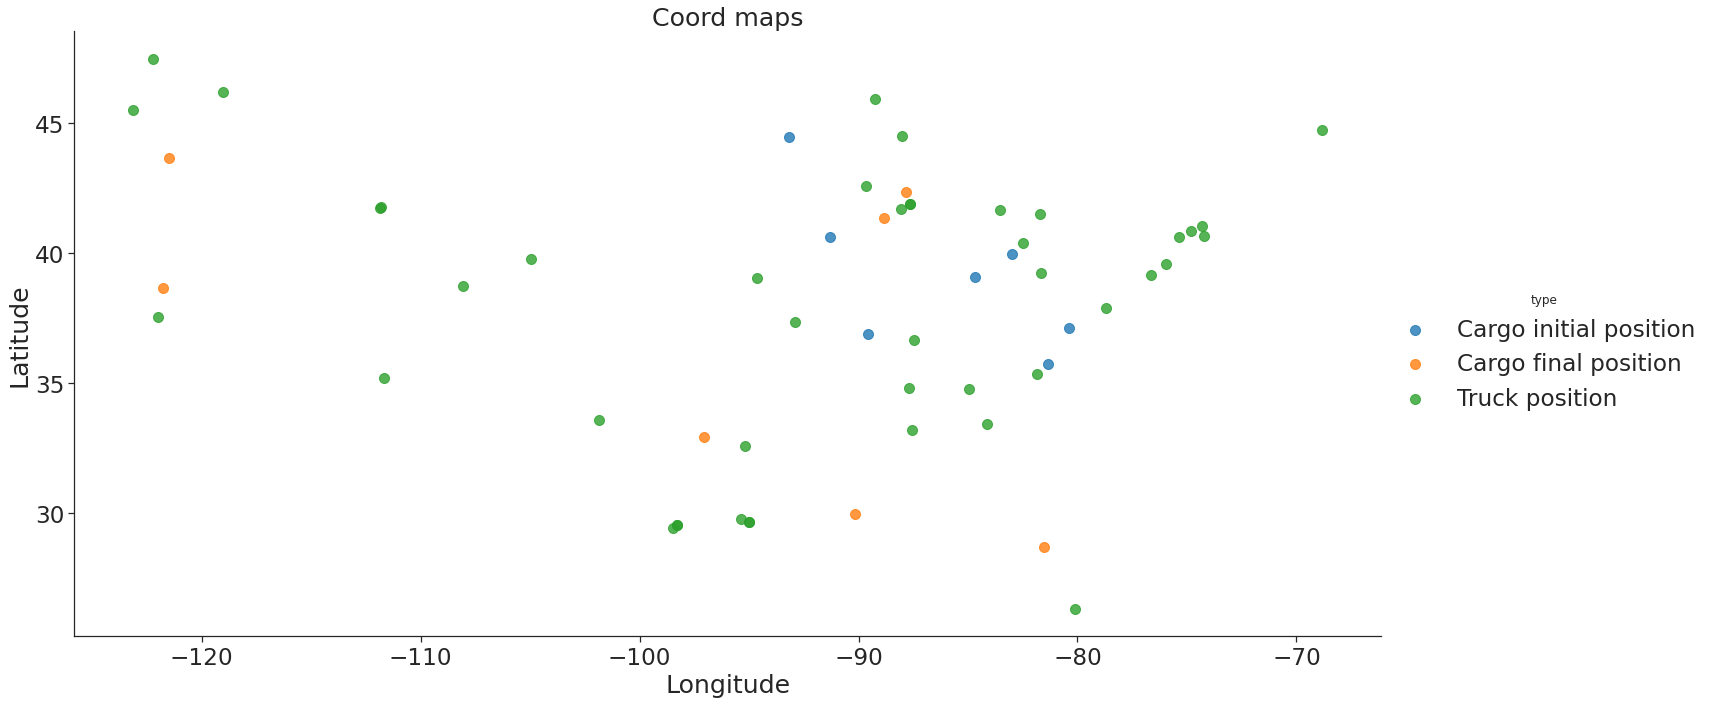

In [11]:
sns.set_context("notebook", font_scale=2.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
ax = sns.lmplot(x='lng', # Horizontal axis
               y='lat', # Vertical axis
               size=10, 
               aspect=2,
               data=df_coords, # Data source
               fit_reg=False, # Don't fix a regression line
               hue="type", # Set color
               scatter_kws={"marker": "D", # Set marker style
                            "s": 100}) # S marker size

# Set title
plt.title('Coord maps')

# Set x-axis label
plt.xlabel('Longitude')

# Set y-axis label
plt.ylabel('Latitude')

#label_point(df_coords.lat, df_coords.lng, df_coords.label, plt.gca()) 

In [12]:
min_lat_sp = cargo["origin_lat"].min()
min_lng_sp = cargo["origin_lng"].min()

max_lat_sp = cargo["origin_lat"].max()
max_lng_sp = cargo["origin_lng"].max()

In [13]:
dist = math.hypot(min_lat_sp - max_lat_sp, min_lng_sp - max_lng_sp)
center = ((min_lat_sp + max_lat_sp)/2, (min_lng_sp + max_lng_sp)/2)
print(dist)
print(center)

15.451081839565083
(40.096376049999996, -86.78527145000001)


# Desenvolvimento do algorítimo

Considerando que a distancia da carga é sempre fixa, ou seja, a distancia do ponto de origem até o ponto de destino de cada carga é sempre o mesmo independente de qual caminhão será utilizado para o seu transporte, podemos considerar então que a questão da otimização está associada entre o local em que o caminhão está e o ponto de origem da carga. Em outras palavras, este é um problema de minimazação de uma matriz de custo. Um dos métodos básicos para resolução deste tipo de problema é a aplicação do [Método Hungaro](https://en.wikipedia.org/wiki/Hungarian_algorithm), que geralmente tem complexidade O(n^3)

## Criando a tabela de custo
Com base no gráfico anterior, para este problema em específico, poderiamos aplicar tecnicas de pré-filtragem dos dados para, por exemplo, desconsiderar aqueles caminhões que estão muito longe de qualquer ponto de origem das cargas. No entanto, num primeiro momento iremos considerá-los nos cálculo e mais tarde se houver oportunidade, acrescentaremos essa melhoria ao algorítimo

In [136]:
cargo["product_city"] = cargo["product"] + "_" + cargo["origin_city"] + "_" + cargo["destination_city"]

In [137]:
df_distances = pd.DataFrame(0,
        index=trucks["truck"],
        columns=cargo['product_city'].values)

R = 6373.0

def calculate_distance(point1:dict, point2:dict) -> float:
    """ Calculate distance between two points (in Km)
    
    :param point1: **first (latitude, longitude) point**.
        dict with lat and lng keys
        
    :param point2: **second (latitude, longitude) point**.
        dict with lat and lng keys
        
    """
    lat1 = radians(point1['lat'])
    lon1 = radians(point1['lng'])
    lat2 = radians(point2['lat'])
    lon2 = radians(point2['lng'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (sin(dlat/2)) ** 2 + cos(lat1) * cos(lat2) * (sin(dlon/2)) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    return distance

Tabela de custo considerando a distância entre caminhões e ponto de origem das cargas, as unidades de distância estão em kilômetros

In [140]:

for truck_index, truck_row in trucks.iterrows():
    for product_index, product_row in cargo.iterrows():

        distance = calculate_distance(
            dict(lat=truck_row['lat'], lng=truck_row['lng']),
            dict(lat=product_row['origin_lat'], lng=product_row['origin_lng'])
            )
        
        df_distances.loc[truck_row['truck'], product_row['product_city']] = distance

display(df_distances.head())

,Light bulbs_Sikeston_Grapevine,Recyclables_Christiansburg_Apopka,Apples_Columbus_Woodland,Wood_Hebron_Jefferson,Cell phones_Hickory_La Pine,Wood_Northfield_Waukegan,Oranges_Fort Madison_Ottawa
truck,,,,,,,
Hartford Plastics Incartford,288.165182,703.551444,707.265188,543.157181,584.325911,1171.845040,722.962915
Beyond Landscape & Design Llcilsonville,2856.836661,3646.724055,3365.732335,3235.865568,3604.778292,2523.727228,2656.652499
Empire Of Dirt Llcquality,1946.232255,1287.208429,1277.618524,1454.063266,1457.041023,1919.488300,1887.263095
James Haas Al Haas Shelly Haasairfield,1228.743411,476.666674,604.448809,755.845395,641.009529,1518.308464,1311.018942
Ibrahim Chimandalpharetta,743.517740,572.152045,195.103129,304.882605,686.818148,839.627455,659.773376


Para podermos aplicar o método hungaro, precisamos que a matriz seja quadrada. Dessa forma iremos criar colunas falsas com o valor zero.

In [141]:
fake_columns_count = len(trucks) - len(cargo) + 1

for i in range(1,fake_columns_count):
    df_distances[f'fake{i}'] = pd.Series(0, index=df_distances.index)

Executa a minimização do custo através da função linear_sum_assignment

In [142]:
cost_matrix = df_distances.astype('float').values
row_ind, col_ind = linear_sum_assignment(cost_matrix)
cost = cost_matrix[row_ind, col_ind].sum()

print(f"Total distance from origin is {cost:.2f} km")


Total distance from origin is 1361.76 km


Com a tabela de custo devidamente otimizada, apresentamos o resultado final que responde a pergunta:    
    - Dada uma carga qualquer que está no ponto A e deve ir para o ponto B. Qual caminhão escolher para ter o menor valor de frete?

In [144]:
TRUCK_IDX = 0
CARGO_IDX = 1

data = []
for item in zip(row_ind, col_ind):
    distance = df_distances.iloc[item[TRUCK_IDX], item[CARGO_IDX]]
    if distance == 0:
        continue

    truck_name = df_distances.iloc[item[TRUCK_IDX]].name
    product_name, origin, destination = \
        df_distances.iloc[:, item[CARGO_IDX]].name.split("_")

    data.append([truck_name,
                 product_name,
                 origin,
                 destination,
                 distance])


In [145]:
print(tabulate(data, headers=['Truck', 'Cargo',
                              'Origin', 'Destination',
                              'Distance from origin (km)']))


Truck                               Cargo        Origin          Destination      Distance from origin (km)
----------------------------------  -----------  --------------  -------------  ---------------------------
Viking Products Of Austin Incustin  Light bulbs  Sikeston        Grapevine                         189.529
Paul J Krez Companyorton Grove      Cell phones  Hickory         La Pine                            64.8443
Gary Lee Wilcoxpencer               Wood         Northfield      Waukegan                          347.271
Ricardo Juradoacramento             Recyclables  Christiansburg  Apopka                            172.511
Kjellberg'S Carpet Oneuffalo        Apples       Columbus        Woodland                           64.9042
Fish-Bones Towingew York            Oranges      Fort Madison    Ottawa                            259.808
Wisebuys Stores Incouverneur        Wood         Hebron          Jefferson                         262.894
